# Laplacian Associative Memory (LAM) - TENSOR

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch

import PIL.Image, math, imageio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/Users/James/opt/anaconda3/envs/dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from parallel.nn import LAM
import libtools

---

### DATA

In [4]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)
img /= np.max(img)
img = torch.from_numpy(img).float()

print('Image:', img.shape, img.dtype)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: torch.Size([200, 200]) torch.float32
min: 0.00 max: 1.00


In [5]:
# src = libtools.preference_map(16, 25, img.shape[0])
src = np.load('../data/mat/SOM_orient_v1.npy')

print('Map:', src.shape, src.dtype)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (200, 200) float64
min: 0.00 max: 6.28


In [6]:
features = libtools.gabor_conv(img, src)
features /= np.max(features)
features = torch.from_numpy(features).float()

print('Features:', features.shape, features.dtype)
print('min:', f"{features.min():.2f}", 'max:', f"{features.max():.2f}")

Features: torch.Size([200, 200]) torch.float32
min: 0.00 max: 1.00


---

### HYPER-PARAMETERS

In [7]:
factor = 3
src = libtools.downsample(src, factor)
features = libtools.downsample(features, factor)

print("Downsampled Source:", features.shape)

Downsampled Source: torch.Size([67, 67])


In [8]:
N = 128**2                              # Neurons | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
alpha = -0.9                            # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]         # N Nodes

sigmaX = 1e-5                           # Spatial Gaussian Scale
sigmaA = 0.5                            # Angular Gaussian Scale

temp = 0.07                             # Activation Probability

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Neurons:', N)
print("Nodes:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Neurons: 16384
Nodes: 4489
Start node: 2244
619.48 point attactors


---

### COMPUTE

In [9]:
W = libtools.construct_SLAM(src, sigmaX, sigmaA) # Adjacency Matrix
W = torch.from_numpy(W).float()

In [11]:
graph = LAM(N, P, prob, W, gamma, "asym", start_node, features, temp) # Weights

Using feature-based initial condition
Sparsity: tensor(0.1083)


In [12]:
m_log, _, _ = graph.simulate_single(alpha, eta, simlen) # Simulate

100%|██████████| 3000/3000 [01:58<00:00, 25.39it/s]


In [13]:
m = m_log[-1,:].clone()
# m[start_node] = np.mean(np.delete(m, start_node))

max_m = m.max()
Nactive = torch.mean(torch.sum((m > 0.5*max_m).float(), dim=0))
print("Maximum overlap:", max_m)
print("Number of patterns:", Nactive)

Maximum overlap: tensor(0.0366)
Number of patterns: tensor(271.)


---

### VISUALIZE

In [14]:
# HSV2RGB
m_norm = m + abs(m.min())
m_norm /= m_norm.max()

hsv_pattern = libtools.grade(src/(2*math.pi), 1.0, m_norm.reshape(src.shape))

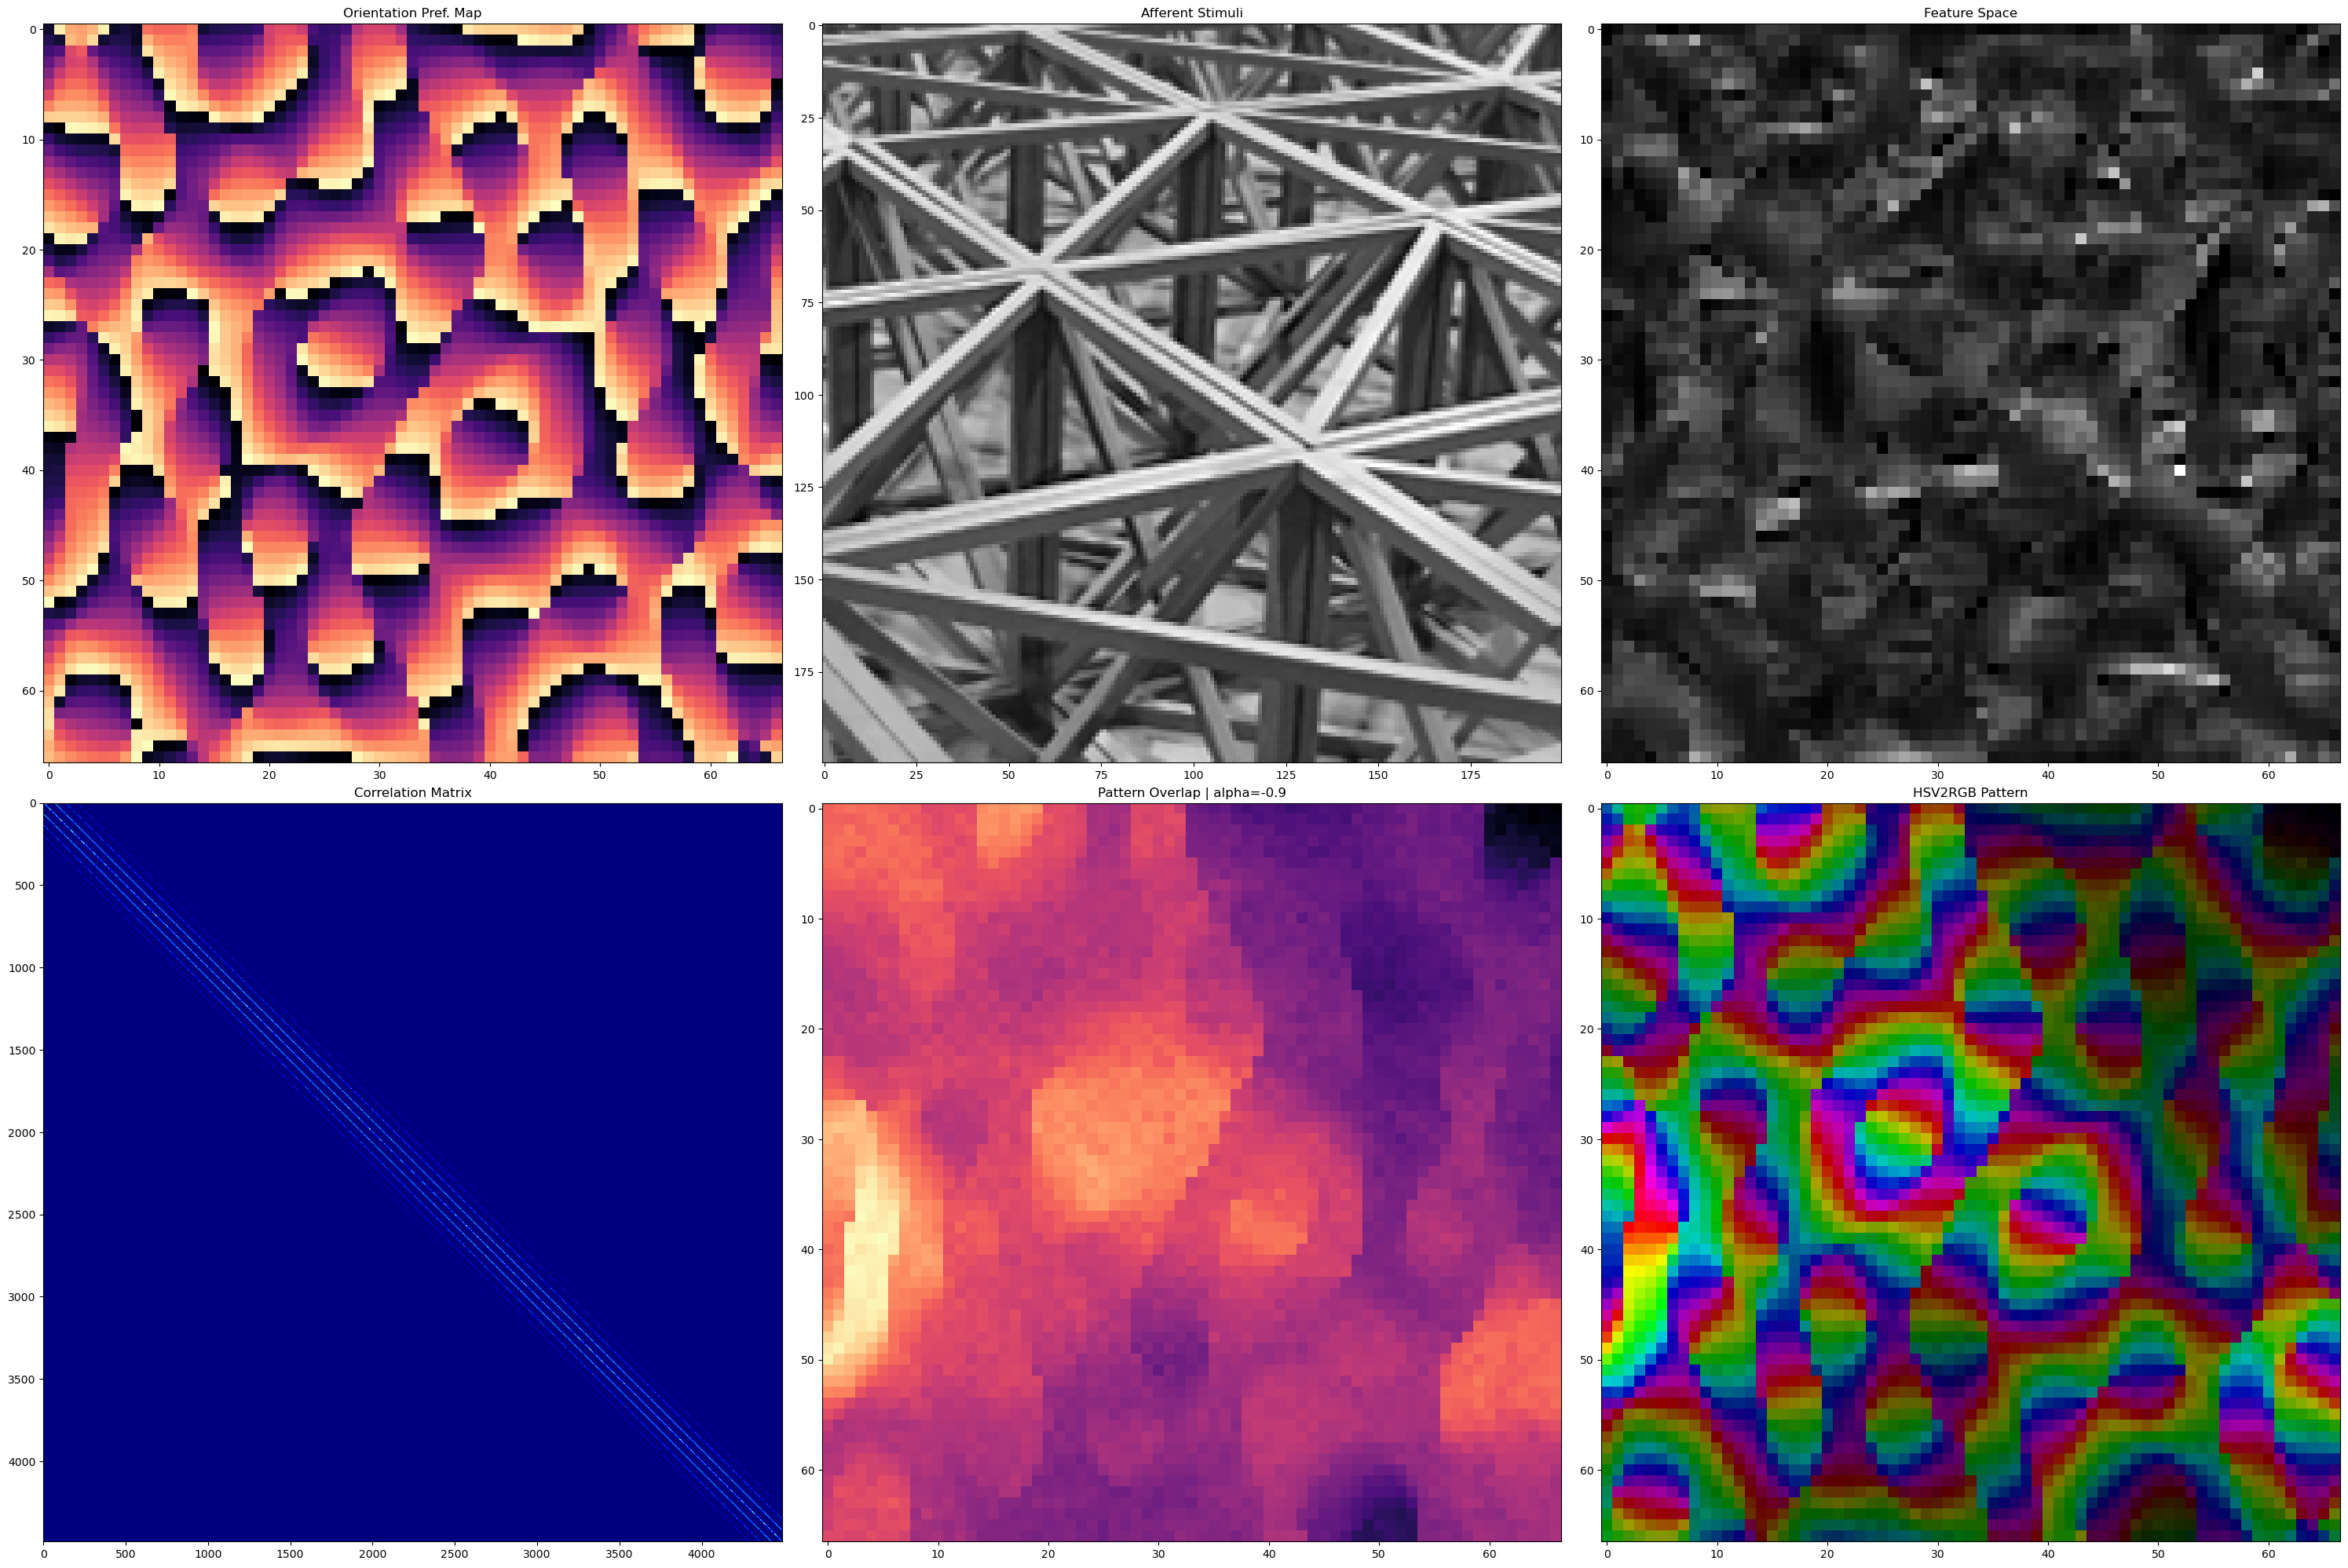

In [15]:
plt.figure(figsize=(30,20))
plt.subplot(2, 3, 1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(2, 3, 2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(2, 3, 3)
plt.imshow(features, 'gray')
plt.title('Feature Space')

plt.subplot(2, 3, 4)
plt.imshow(W, 'jet')
plt.title('Correlation Matrix')

plt.subplot(2, 3, 5)
plt.imshow(m.reshape(src.shape), 'magma')
plt.title("Pattern Overlap | alpha=" + str(alpha))

plt.subplot(2, 3, 6)
plt.imshow(hsv_pattern)
plt.title("HSV2RGB Pattern")
plt.tight_layout()